<p style="text-align: center;"><img src="http://www.ucm.es/logo/ucm.png" alt="ucm" style="height: 100px;"/>   <img src="https://www.ucm.es/data/cont/media/www/pag-18458/logo_aocg.jpg" alt="aocg" style="height: 100px;"/> 

&nbsp;

<div align="center"> 
<font size=5> Universidad Complutense de Madrid</font>
</div>
    
<div align="center"> 
<font size=4> Grupo Computense de Óptica Aplicada </font>
</div>
&nbsp;

&nbsp;



    
<div align="center"> 
<font size=6> Fresnel-based DOE + SLM Stokes analyzer </font>
</div>

- **Fecha**: 2022/03/18
        
- **Autores**: 
    - Javier Alda
    - Luis Miguel Sánchez Brea
    - Jesús del Hoyo

   
- **Estado**:  Funciona, se valida la prueba de concepto (**guardar**). 

- **Objetivos**: 
    - Desarrollo teórico. Prueba de concepto.
    - Creación de una  SFZP (sectorized Fresnel Zone Plate) polarizante para obtener los vectores de Stokes de un punto de vista experimental.
   

- **Descripción** 
     - Prueba de concepto de creación de una máscara formada por una SFZP (sectorized Fresnel Zone Plate) para obtener los vectores de Stokes. 
     - Se divide un espacio circular en varias secciones, En cada una de ellas se coloca una lente ligeramente desplazada del centro. A cada uno de los sectores, además del SFZP, se coloca un polarizador.
     - Una vez generada la máscara vectorial, se realizan diversas pruebas con fuentes de luz polarizadas. Se demuestra que se obtienen intensidades de luz en cada foco directamente relacionados con el estado de polarización.
     - Se ubican fotodetectores y se integran las señales.

- **Referencias**: Based on diffractio py module

- **Conclusiones**: 
    - Los resultados salen. 
    - Aquí utilizamos estados de polarización puros (polarizador lineal y polarizador circular). Es necesario sustituir el estado de polarizador circular (no fabricable fácilmente) por otro estado más fabricable (lámina $\lambda$/4 + Polarizador lineal.
    - Hay que pensar un procedimiento de fabricación:
        1. Máscara de amplitud + polarizadores recortados
        2. SLM. En este caso nos tenemos que adaptar a los polarizadores que nos proporciona el SLM.



# Importaciones

In [1]:
%load_ext autoreload
%autoreload 2

In [58]:
import diffractio
import matplotlib as mpl


from scipy.optimize import curve_fit

from diffractio import degrees, mm, plt, sp, um, np, nm
from diffractio.scalar_fields_XY import Scalar_field_XY
from diffractio.utils_drawing import draw_several_fields
from diffractio.scalar_masks_XY import Scalar_mask_XY
from diffractio.scalar_sources_XY import Scalar_source_XY

from diffractio.vector_sources_XY import Vector_source_XY
from diffractio.vector_masks_XY import Vector_mask_XY
from diffractio.vector_fields_XY import Vector_field_XY

from diffractio.utils_drawing import draw_several_fields

In [3]:
from py_pol.jones_matrix import Jones_matrix
from py_pol.jones_vector import Jones_vector
from py_pol.stokes import Stokes

In [4]:
from py_aocg.stokes_analyzer.stokes_analyzer import (Detector, Stokes_analyzer, compute_stokes_mask, states_standard, states_SLM, 
                                                     compute_several_stokes_masks, define_random_jones_vectors)

In [5]:
mpl.rcParams['figure.dpi'] = 250 #dpi
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.formatter.useoffset'] = False

In [6]:
np.printoptions(precision=4);
import warnings
warnings.filterwarnings('ignore') 

### Generation of the Polarization State Analyzer with N fresnel zones

In [7]:
num_sectors = 6
angulosector = 360/num_sectors
focal = 100 * mm
r_shift = .75 * mm
detector_radius = 100*um

has_draw = True



In [8]:
num_pixels = 256

length = 4*mm
x0 = np.linspace(-length / 2, length / 2, num_pixels)
y0 = np.linspace(-length / 2, length / 2, num_pixels)
wavelength = 0.6238 * um

Deprecated: use stokes_analyzer_lens_indexes


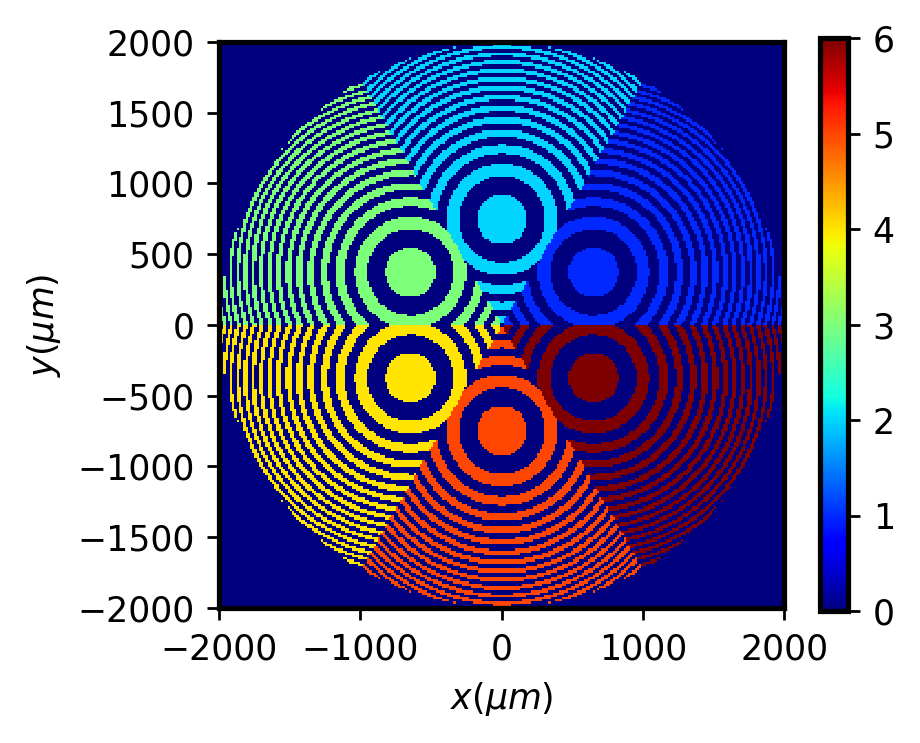

In [9]:
i_stokes_analyzer = Stokes_analyzer(x0, y0, wavelength)
i_stokes_analyzer.stokes_analyzer_lens(focal, r_shift, num_sectors=6)
i_stokes_analyzer.draw(kind='amplitude', has_colorbar='vertical', colormap_kind='jet'); plt.clim(vmin=0)

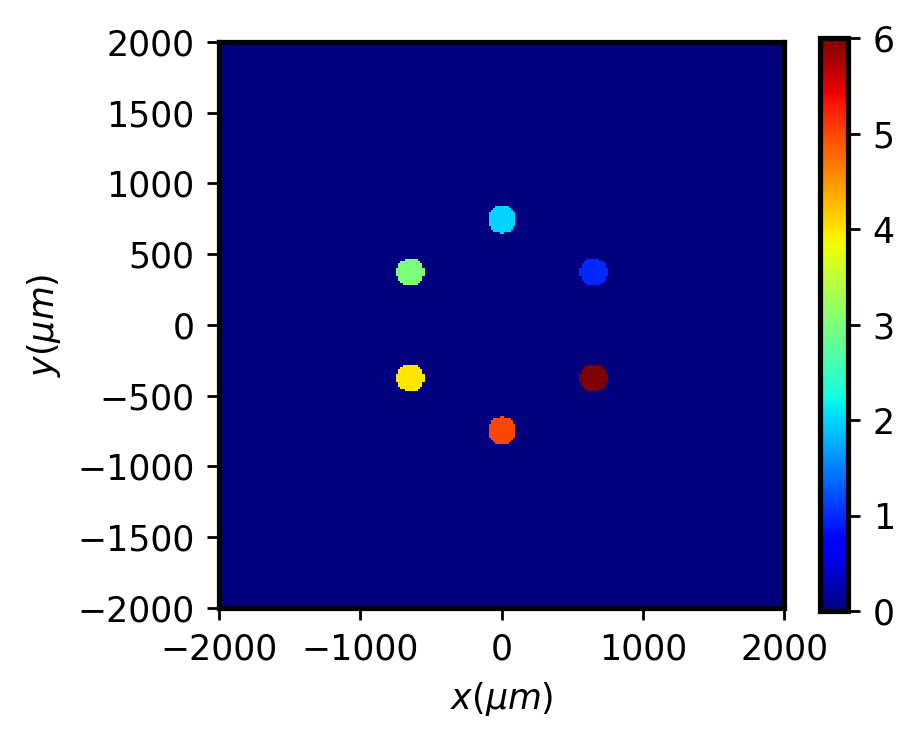

In [10]:
detector = Detector(x0, y0, wavelength)
detector.circular(focal, r_shift,    detector_radius= detector_radius,   num_sectors=num_sectors,  has_draw=True)
detector.draw(kind='amplitude', has_colorbar='vertical', colormap_kind='jet'); plt.clim(vmin=0)

## Añadir detector central

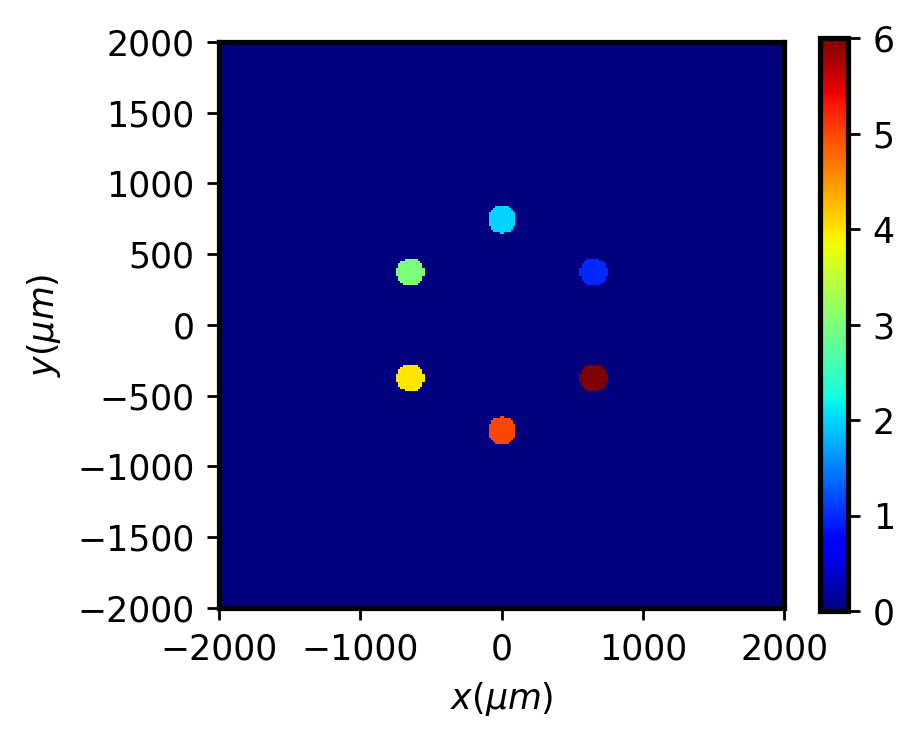

In [11]:
# self = detector
t_detector = Scalar_mask_XY(detector.x, detector.y, detector.wavelength)
t_detector.circle(r0=(0,0), radius=detector_radius)
#detector.add_central_detector(t_detector)
detector.draw(kind='amplitude', has_colorbar='vertical', colormap_kind='jet'); plt.clim(vmin=0)

# Generación de máscara vectorial

## Asignación de estados de polarización a cada uno de los índices

In [12]:
data = np.load("Optimizacion_SLM_polarimetria.npz")
print(data["indices"])
print(data["cost"])
States = states_SLM(data["indices"])


[226 129 121 107   0   7]
31.64714116850728


In [13]:
# States = states_standard()

## Creación de máscara vectorial

<Figure size 1000x1000 with 0 Axes>

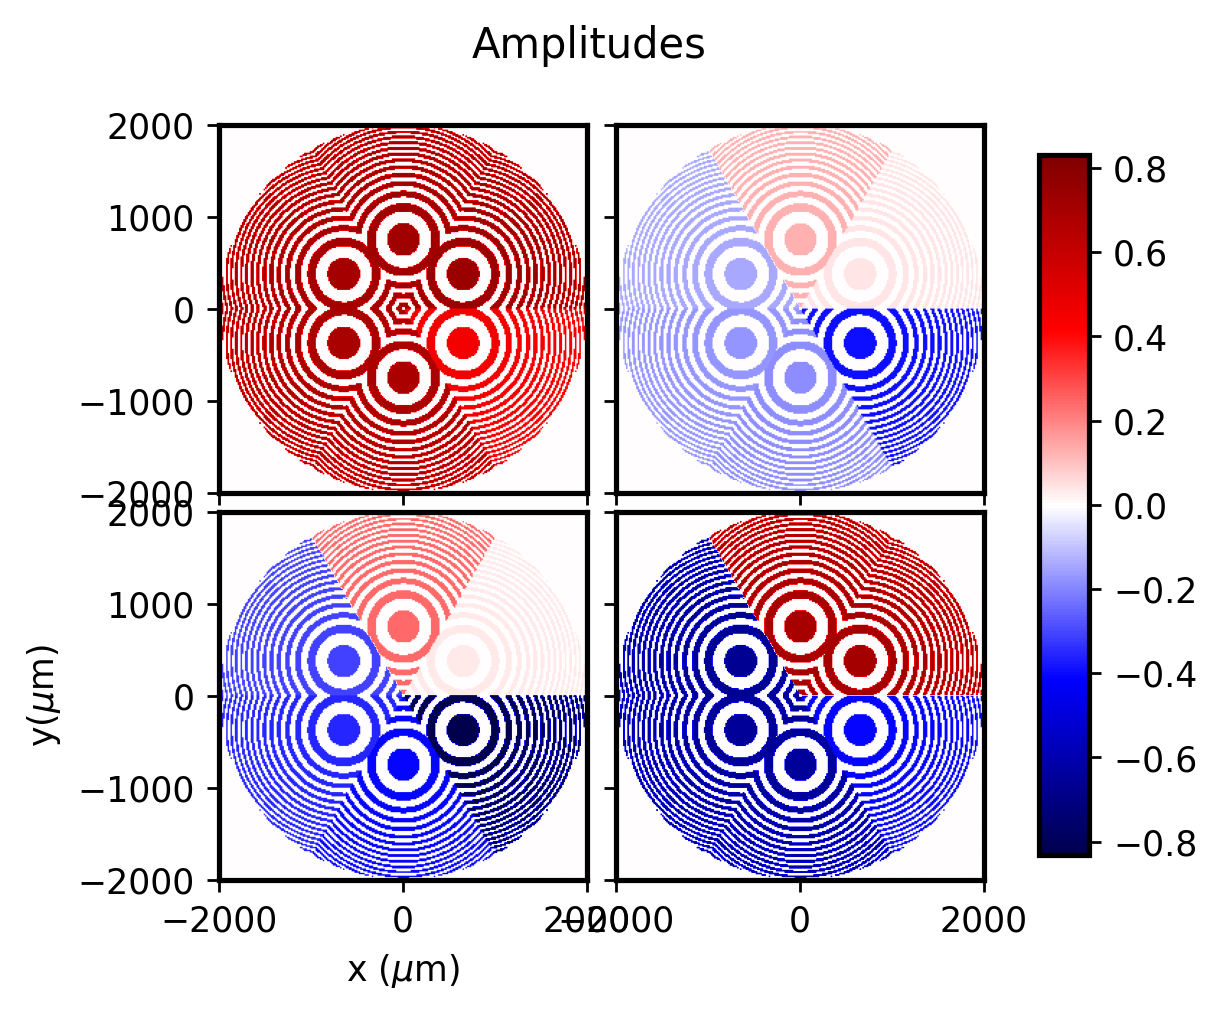

In [14]:
mask_vector_0 = Vector_mask_XY(x=x0, y=y0, wavelength=wavelength)
mask_vector_0.multilevel_mask(mask=i_stokes_analyzer, states=States, discretize=False, normalize=False)
mask_vector_0.draw('amplitude');

# Calculo de los detectores. Generamos detectores centrados en los puntos focales


In [15]:
standard_vectors=[(1,0), (0,1), (1/np.sqrt(2),1/np.sqrt(2)), (1/np.sqrt(2),-1/np.sqrt(2)), (1/np.sqrt(2),1j/np.sqrt(2)), (1/np.sqrt(2),-1j/np.sqrt(2))]

In [16]:
Jz_out, Signals, Stokes_results, Jones_results, Error = compute_several_stokes_masks(standard_vectors,
                                 mask_vector_0,
                                 detector,
                                 focal,
                                 r_shift,
                                 num_sectors=6,
                                 Wi=data["Wi"],
                                 has_draw=False,
                                 has_background=False);

0, error = 6.50 %
1, error = 8.94 %
2, error = 5.06 %
3, error = 8.78 %
4, error = 8.75 %
5, error = 24.20 %


# - con 256 x 256
- 0, error = 6.50 %
- 1, error = 8.94 %
- 2, error = 5.06 %
- 3, error = 8.78 %
- 4, error = 8.75 %
- 5, error = 24.20 %

# con 512 x 512
- 0, error = 4.35 %
- 1, error = 6.13 %
- 2, error = 5.38 %
- 3, error = 5.79 %
- 4, error = 4.94 %
- 5, error = 14.89 %

# con 1024 x 1024 
- 0, error = 2.82 %
- 1, error = 6.33 %
- 2, error = 6.71 %
- 3, error = 5.05 %
- 4, error = 5.50 %
- 5, error = 13.49 %




In [99]:
num_data = 512
range_hist=(0,0.25)
bins = 25

In [75]:
random_jones_vectors = define_random_jones_vectors(num_data)

In [32]:
Jz_out, Signals, Stokes_results, Jones_results, Error = compute_several_stokes_masks(random_jones_vectors,
                                 mask_vector_0,
                                 detector,
                                 focal,
                                 r_shift,
                                 num_sectors=6,
                                 Wi=data["Wi"],
                                 has_draw=False,
                                 has_background=False);

In [212]:
hist_error-0.5

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24.])

In [213]:
poisson.pmf(hist_error-0.5, 5)

array([6.73794700e-03, 3.36897350e-02, 8.42243375e-02, 1.40373896e-01,
       1.75467370e-01, 1.75467370e-01, 1.46222808e-01, 1.04444863e-01,
       6.52780393e-02, 3.62655774e-02, 1.81327887e-02, 8.24217669e-03,
       3.43424029e-03, 1.32086165e-03, 4.71736303e-04, 1.57245434e-04,
       4.91391982e-05, 1.44527054e-05, 4.01464038e-06, 1.05648431e-06,
       2.64121077e-07, 6.28859708e-08, 1.42922661e-08, 3.10701437e-09,
       6.47294660e-10])

In [237]:
def determine_histogram(Error, has_draw=True, bins=25, range_hist=(0,25)):
    Error = np.array(Error)
    Error = Error * 100
    freq, hist_error = np.histogram(Error, bins=bins, range=range_hist)
    diff = hist_error[1]-hist_error[0]
    hist_error = hist_error[:-1]+diff/2

    
    
    if has_draw:
        plt.hist(Error, bins=bins, range=range_hist);
        plt.plot(hist_error, freq, 'ko')
        
    return freq, hist_error
    ### fit histogram at 

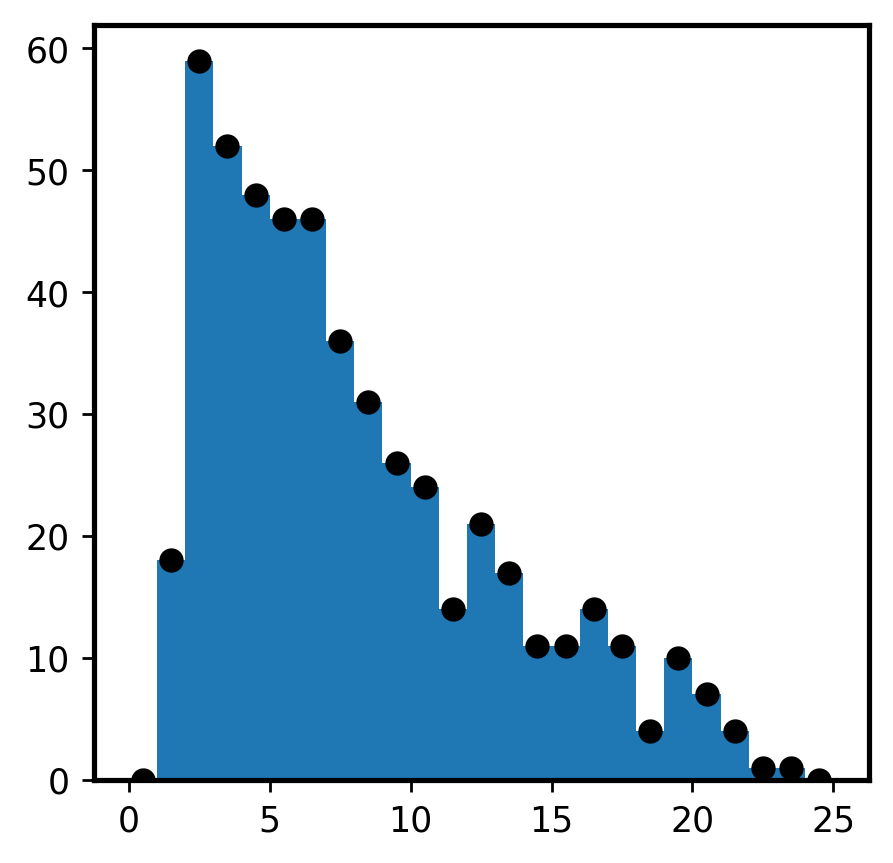

In [238]:
freq, hist_error = determine_histogram(Error)